<div class="title">Práctica: Series Temporales y Árbol de Regresión</div>
<div class="subtitle">Máster Executive en Data Science y Big Data en Finanzas</div>
<div class="author">Eugenio Gil Ocaña</div>

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>
%matplotlib inline

In [206]:
#importamos paquetes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [207]:
#leemos los datos
df = pd.read_csv('demandaElectrica_y_Temperatura_Nacional.csv')
df_total = pd.read_csv('demandaElectrica_y_Temperatura_Nacional.csv')

In [208]:
#descripción de las variables
print(df.dtypes)
print(df.shape)

fecha       object
demanda    float64
tmax       float64
tmin       float64
dtype: object
(1826, 4)


In [209]:
#pasamos la variable fecha a datetime
df['fecha'] = pd.to_datetime(df['fecha'])
#Setting index
df= df.set_index('fecha')   

In [210]:
df.head()

,demanda,tmax,tmin
fecha,,,
2017-01-01,563508.834,9.540657,0.609208
2017-01-02,695578.332,10.663463,2.046818
2017-01-03,750407.667,12.680494,2.702876
2017-01-04,746000.168,13.827170,3.215307
2017-01-05,713015.168,13.683669,2.950880


In [211]:
df.describe()

,demanda,tmax,tmin
count,1826.000000,1826.000000,1826.000000
mean,678462.939245,22.016280,10.807810
std,69272.788320,6.915573,5.739313
min,476520.165000,5.258622,-2.888478
25%,630715.375000,16.101565,6.149195
50%,682510.500500,21.467848,10.349215
75%,728683.002000,28.256244,16.042972
max,847353.832000,37.183374,22.159456


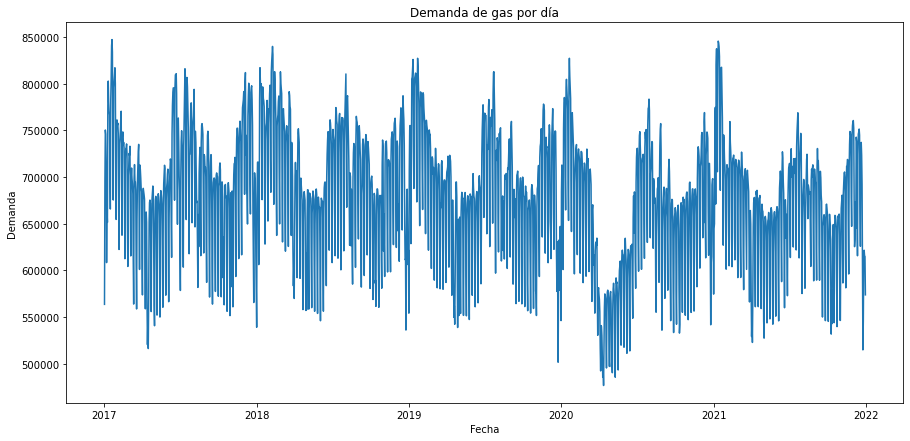

In [212]:
#pintamos los datos
plt.figure(figsize=(15,7))
plt.title('Demanda de gas por día')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.plot(df.index,df['demanda'])
plt.show()

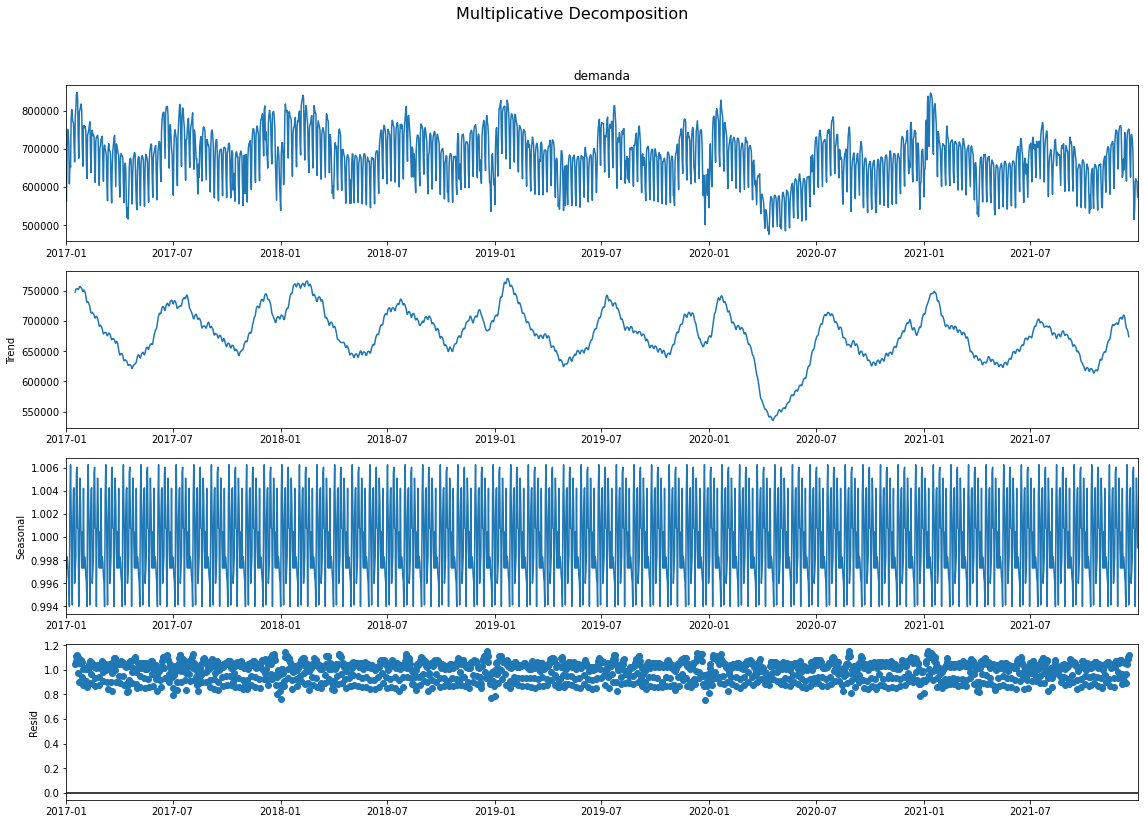

In [213]:
#seguimos pintando los datos para encontar posible tendencia de forma visual

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

#Descomposición multiplicativa
multiplicative_decomposition = seasonal_decompose(df['demanda'], model='multiplicative', period=30)

# Pintamos de nuevo
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

A primera vista los datos parecen estacionarios. Se aprecian ciclos de temporada y una caída en la demanda en 2020 causada por el covid-19. 

In [214]:
#arreglamos el dataframe para trabajar con él. Eliminamos las variables de temperatura
df = df.drop(['tmax', 'tmin'], axis = 'columns')

In [215]:
#examinamos mejor el conjunto de datos
df_des = df
df_des = df_des.reset_index()
df_des['year'] = df_des['fecha'].dt.year
df_des['month'] = df_des.fecha.dt.month
df_des['day'] = df_des.fecha.dt.dayofyear
df_des['weekday'] = df_des.fecha.dt.weekday
df_des['year-month'] = df_des.fecha.apply(lambda x: str(x.year)+'-'+str(x.month))

<AxesSubplot:title={'center':'Demanda por día.'}, xlabel='weekday', ylabel='demanda'>

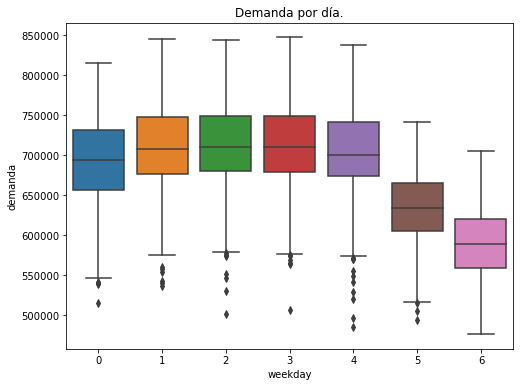

In [216]:
#podemos ver la caída de la demanda en fin de semana
import seaborn as sns
plt.rcParams.update({'figure.figsize': (8,6)})
plt.title("Demanda por día.")
sns.boxplot(x="weekday", y="demanda", data=df_des)

<AxesSubplot:title={'center':'Demanda por mes'}, xlabel='month', ylabel='demanda'>

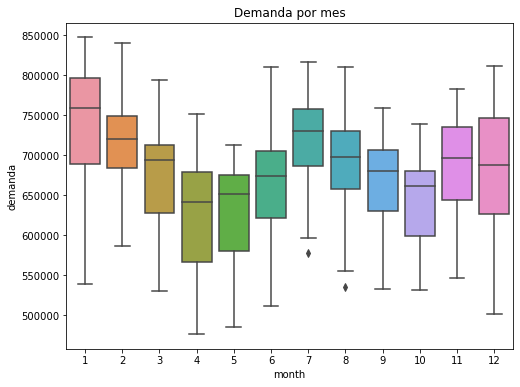

In [218]:
#podemos ver la variación de la demanda dentro del año
import seaborn as sns
plt.rcParams.update({'figure.figsize': (8,6)})
plt.title("Demanda por mes")
sns.boxplot(x="month", y="demanda", data=df_des)

<AxesSubplot:title={'center':'Demanda de todos los años'}, xlabel='year-month', ylabel='demanda'>

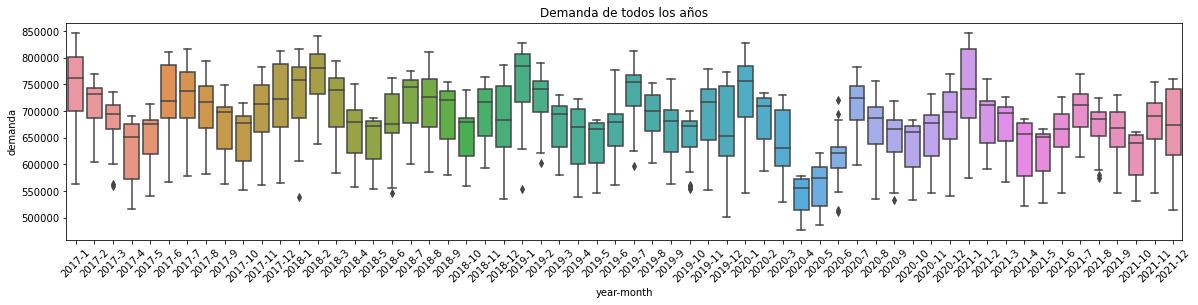

In [219]:
#por último observamos la demanda en boxplot por mes y año
plt.figure(figsize=(20,4))
plt.xticks(rotation=45)
plt.title('Demanda de todos los años')
sns.boxplot(x="year-month", y="demanda", data=df_des)

In [220]:
#creamos un dataframe de festivos para utilizar en el modelo SARIMAX
calendar = pd.DataFrame(df.index)
calendar['month'] = calendar.fecha.dt.month
calendar['day'] = calendar.fecha.dt.day

In [221]:
calendar['1en'] = np.where((calendar['day'] == 1) & (calendar['month']== 1), 1, 0)
calendar['6en'] = np.where((calendar['day'] == 6) & (calendar['month']== 1), 1, 0)
calendar['19mar'] = np.where((calendar['day'] == 19) & (calendar['month']== 3), 1, 0)
calendar['5may'] = np.where((calendar['day'] == 1) & (calendar['month']== 5), 1, 0)
calendar['15ago'] = np.where((calendar['day'] == 15) & (calendar['month']== 8), 1, 0)
calendar['12oct'] = np.where((calendar['day'] == 12) & (calendar['month']== 10), 1, 0)
calendar['1nov'] = np.where((calendar['day'] == 1) & (calendar['month']== 11), 1, 0)
calendar['6dic'] = np.where((calendar['day'] == 6) & (calendar['month']== 12), 1, 0)
calendar['8dic'] = np.where((calendar['day'] == 8) & (calendar['month']== 12), 1, 0)
calendar['25dic'] = np.where((calendar['day'] == 25) & (calendar['month']== 12), 1, 0)

calendar = calendar.drop(['month', 'day'], axis = 'columns')
calendar = calendar.set_index('fecha')

In [222]:
#festivos nacionales
calendar.head(6)

,1en,6en,19mar,5may,15ago,12oct,1nov,6dic,8dic,25dic
fecha,,,,,,,,,,
2017-01-01,1,0,0,0,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0
2017-01-03,0,0,0,0,0,0,0,0,0,0
2017-01-04,0,0,0,0,0,0,0,0,0,0
2017-01-05,0,0,0,0,0,0,0,0,0,0
2017-01-06,0,1,0,0,0,0,0,0,0,0


In [223]:
#separamos el df de forma manual entre test y train
df_test = df.tail(356)
df_train = df.head(1470)

In [224]:
#dickey-fuller test
#H0: The time series is non-stationary
#HA: The time series is stationary

from statsmodels.tsa.stattools import adfuller
def adfuller_test(demanda):
    result = adfuller(demanda)
    labels = ['ADF test statistics', 'P-value', '#Lags used', 'Number of observation used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis (Ho), Reject the null hypothesis, Data has no unit root and is stationary')
    else:
        print('Weak evidence against the null hypothesis (Ho), time series has a unit root, indicating it is non stationary. ')
        
        
adfuller_test(df_train)

ADF test statistics : -4.0960636709667195
P-value : 0.0009831368215813116
#Lags used : 21
Number of observation used : 1448
Strong evidence against the null hypothesis (Ho), Reject the null hypothesis, Data has no unit root and is stationary


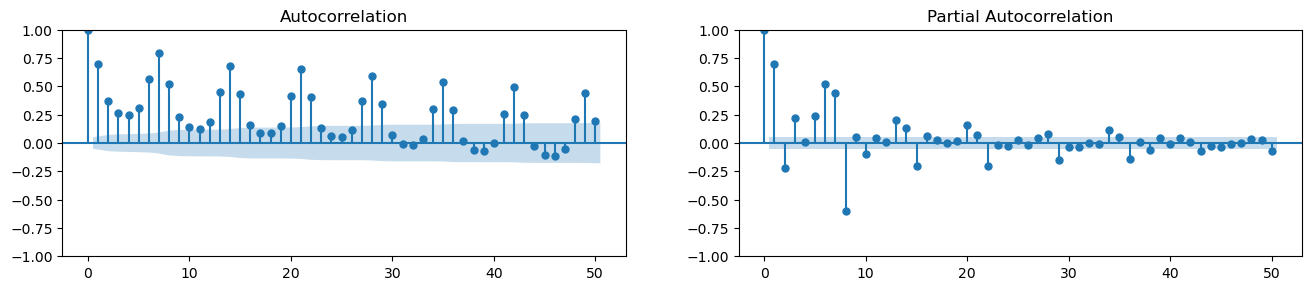

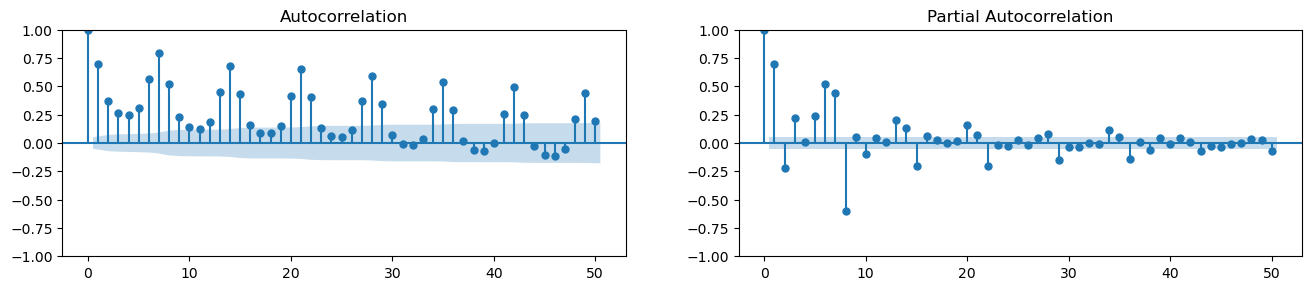

In [225]:
#antes aplicar el modelo miramos la autocorrelación y la autocorrelación parcial entre lags
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_train['demanda'].tolist(), lags=50, ax=axes[0]) #ma
plot_pacf(df_train['demanda'].tolist(), lags=50, ax=axes[1], method ='ywm') #ar

Observamos que la autocorrelación se mantiene hasta los 50 lags, con un patrón marcado

In [226]:
#indicamos la frecuencia de los datos a python
df_train.index.freq = "D"
frequency = df_train.index.freq = "D"

In [227]:
#construimos un AR(1) simple para empezar a trabajar
#vemos que el AR(1) es significativo y no se va a 1 a pesar de no haber diferenciado
from statsmodels.tsa.arima.model import ARIMA

# 1,0,0 ARIMA Model
model1 = ARIMA(df_train, order=(1,0,0), freq=frequency)
model_fit1 = model1.fit()
print(model_fit1.summary())

                               SARIMAX Results                                
Dep. Variable:                demanda   No. Observations:                 1470
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -18015.318
Date:                Sun, 09 Oct 2022   AIC                          36036.636
Time:                        19:52:01   BIC                          36052.515
Sample:                    01-01-2017   HQIC                         36042.557
                         - 01-09-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.813e+05   4771.674    142.776      0.000    6.72e+05    6.91e+05
ar.L1          0.6969      0.020     35.626      0.000       0.659       0.735
sigma2       2.58e+09      0.005   5.54e+11      0.0

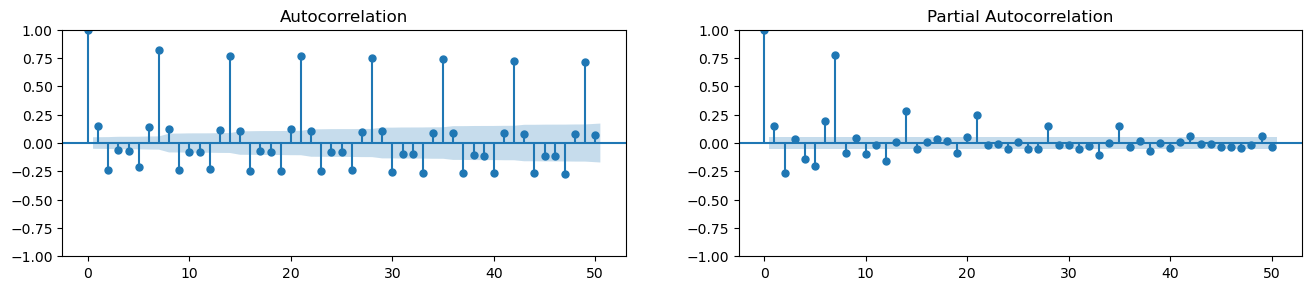

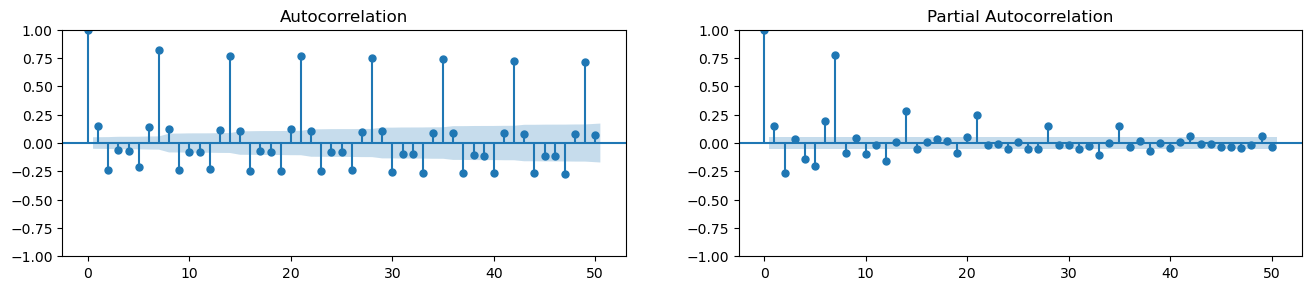

In [228]:
#volvemos a dibujar ACF y PACF
residuals = pd.DataFrame(model_fit1.resid)

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(residuals, lags=50, ax=axes[0]) #ma
plot_pacf(residuals, lags=50, ax=axes[1], method = 'ywm') #ar

A pesar de la 'seasonality' aún observada en las autocorrelaciones, el modelo se ajusta correctamente

In [229]:
# 1,0,1 ARIMA Model
#Probamos con un ARIMA(1,0,1)
model2 = ARIMA(df_train, order=(1,0,1), freq=frequency)
model_fit2 = model2.fit()
print(model_fit2.summary())

                               SARIMAX Results                                
Dep. Variable:                demanda   No. Observations:                 1470
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -17948.078
Date:                Sun, 09 Oct 2022   AIC                          35904.156
Time:                        19:52:13   BIC                          35925.328
Sample:                    01-01-2017   HQIC                         35912.051
                         - 01-09-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.813e+05   3930.286    173.342      0.000    6.74e+05    6.89e+05
ar.L1          0.4584      0.030     15.137      0.000       0.399       0.518
ma.L1          0.4870      0.036     13.375      0.0

El MA(1)también es significativo no afecta al Log likelyhood y como vemos mejora la autocorrelación de los residuos

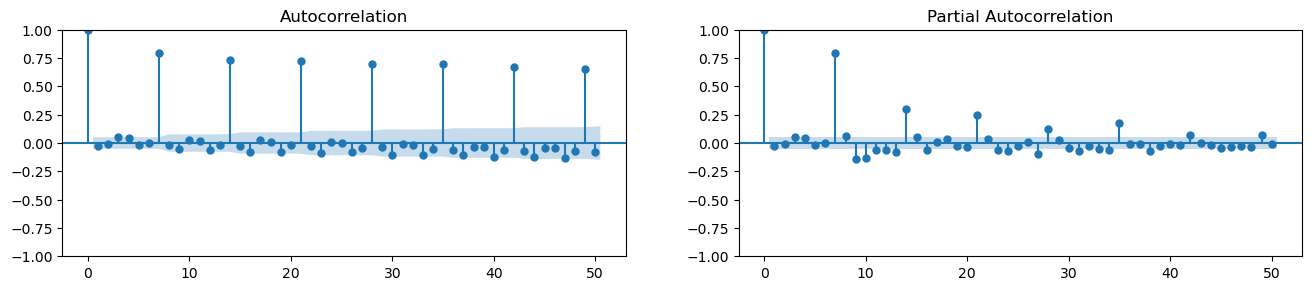

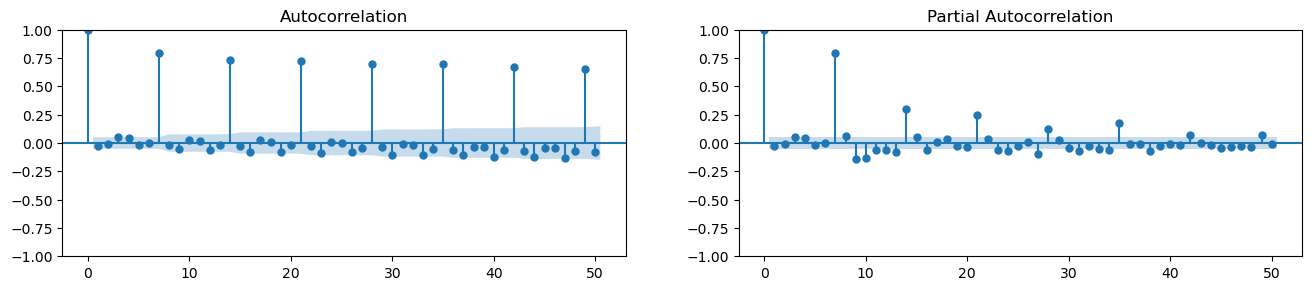

In [232]:
#ACF & PACF
residuals2 = model_fit2.resid

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(residuals2, lags=50, ax=axes[0]) #ma
plot_pacf(residuals2, lags=50, ax=axes[1], method = 'ywm') #ar

In [234]:
#probamos a introducir un componente temporal cada 7 días para indicar los domingos
# 1,0,1 ARIMA Model con seasonal component
model3 = ARIMA(df_train, order=(1,0,1), freq=frequency, seasonal_order = (0,0,1,7))
model_fit3 = model3.fit()
print(model_fit3.summary())

                                    SARIMAX Results                                    
Dep. Variable:                         demanda   No. Observations:                 1470
Model:             ARIMA(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood              -17633.468
Date:                         Sun, 09 Oct 2022   AIC                          35276.937
Time:                                 19:53:21   BIC                          35303.402
Sample:                             01-01-2017   HQIC                         35286.806
                                  - 01-09-2021                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.813e+05   7876.859     86.492      0.000    6.66e+05    6.97e+05
ar.L1          0.4854      0.055      8.775      0.000     

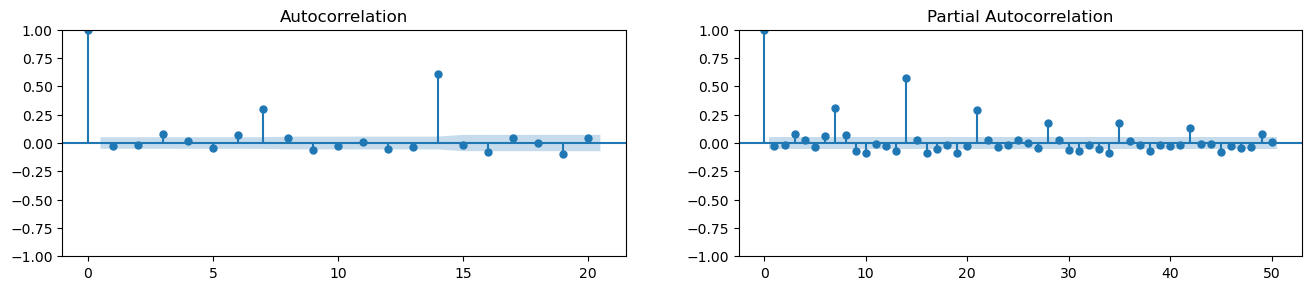

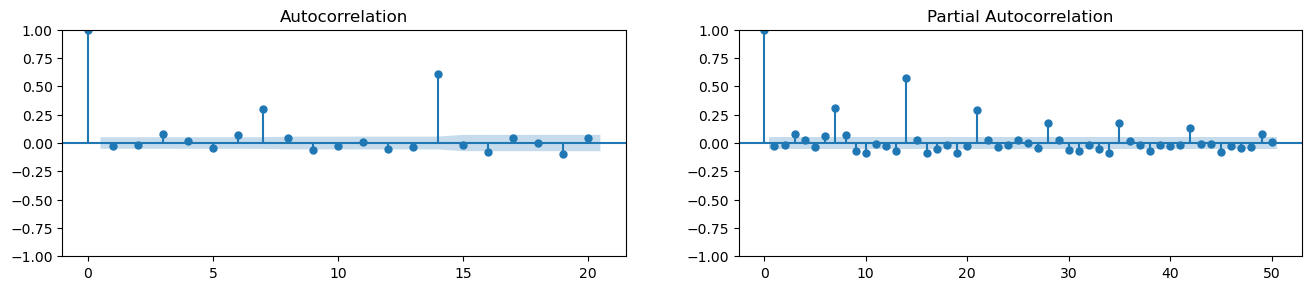

In [235]:
residuals3 = model_fit3.resid

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(residuals3, lags=20, ax=axes[0]) #ma
plot_pacf(residuals3, lags=50, ax=axes[1], method = 'ywm') #ar

El modelo 3 presenta un buen comportamiento a pesar de tener algún regresor no significativo. Las autocorrelaciones dejan de ser significativas pero no se acaba de ajustar como podemos ver a continuación. Al mismo tiempo el Ljung-box test no todos los p-valores están por debajo del umbral

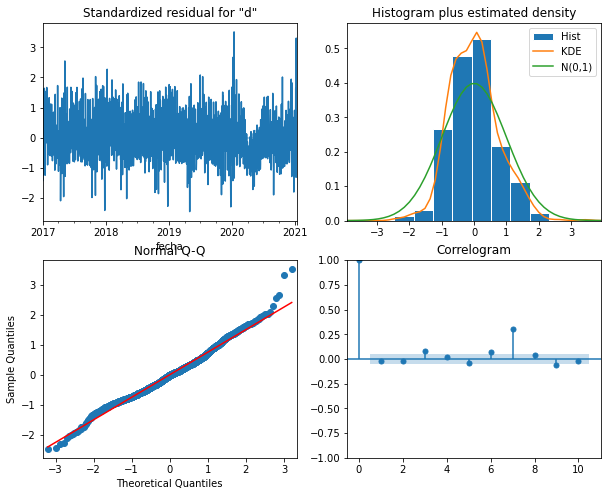

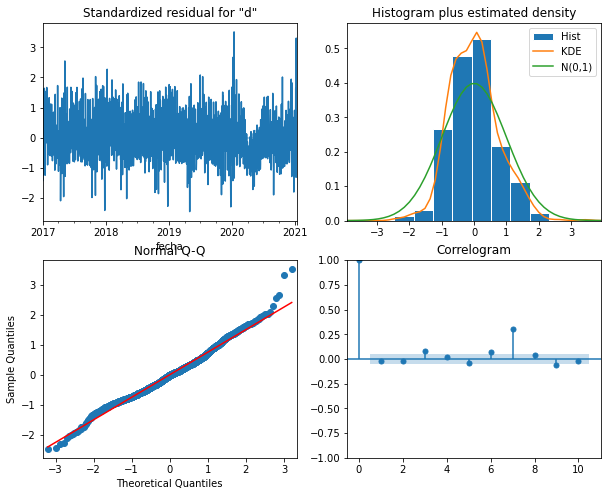

In [236]:
model_fit3.plot_diagnostics(figsize=(10,8))

In [237]:
from statsmodels.stats.diagnostic import acorr_ljungbox

pvalue = acorr_ljungbox(residuals3, np.arange(1, 11, 1))
print(pvalue)

       lb_stat     lb_pvalue
1     0.742588  3.888331e-01
2     1.126864  5.692521e-01
3    11.146284  1.096060e-02
4    11.773226  1.911975e-02
5    14.283813  1.390364e-02
6    21.305637  1.616435e-03
7   157.093842  1.311044e-30
8   159.591043  1.947409e-30
9   165.804826  4.610827e-31
10  166.666736  1.358116e-30


In [239]:
model4 = ARIMA(df_train, order=(1,0,0), freq=frequency, seasonal_order = (0,1,1,7))
model_fit4 = model4.fit()
print(model_fit4.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           demanda   No. Observations:                 1470
Model:             ARIMA(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood              -17039.536
Date:                           Sun, 09 Oct 2022   AIC                          34085.072
Time:                                   19:54:16   BIC                          34100.937
Sample:                               01-01-2017   HQIC                         34090.990
                                    - 01-09-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8837      0.004    226.852      0.000       0.876       0.891
ma.S.L7       -0.9587      0.010    -92.710

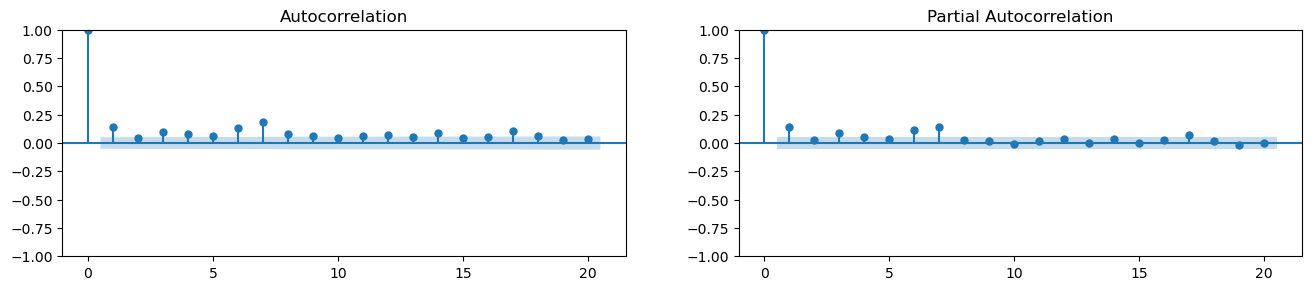

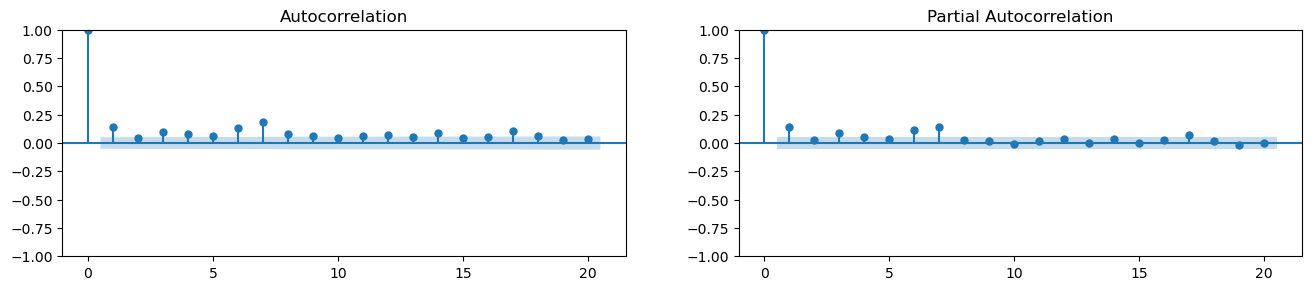

In [240]:
residuals4 = model_fit4.resid

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(residuals4, lags=20, ax=axes[0]) #ma
plot_pacf(residuals4, lags=20, ax=axes[1], method = 'ywm') #ar

el mejor fit hasta ahora es un (1,0,0)(0,1,1,7).
vamos a probar automatizando el proceso

In [157]:
order_aic_bic=[]

# Loop p
for p in range(7):
  # Loop q
    for q in range(7):
        # create and fit ARMA(p,q) model
        model_a = SARIMAX(df, order=(p,0,q), freq='D') 
        results = model_a.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p,q,results.aic, results.bic))

C:\Users\eugeniogil\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\eugeniogil\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\eugeniogil\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\eugeniogil\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\e

In [160]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','q','AIC','BIC'])

# Print order_df in order of increasing AIC
order_df.sort_values('AIC')

#el mejor modelo sugerido es un 6,6

,p,q,AIC,BIC
48,6,6,34522.766061,34591.575291
46,6,4,34653.319332,34711.542527
47,6,5,34683.496473,34747.012685
41,5,6,34929.740447,34993.256659
40,5,5,34945.751376,35003.974570
44,6,2,34957.650226,35005.287385
39,5,4,35019.767913,35072.698090
38,5,3,35042.448514,35090.085673
45,6,3,35210.970011,35263.900188
31,4,3,35241.818311,35284.162452


el (6,0,6)presenta el mejor resultado en BIC y AIC pero no consigue eliminar la autocorrelación de los residuos

In [241]:
# Forecast
fc3= model_fit3.forecast(15, alpha=0.05)  # 95% conf
fc4= model_fit4.forecast(15, alpha=0.05)  # 95% conf

In [242]:
import numpy as np
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    return mape

In [243]:
print(forecast_accuracy(fc3, df_test.demanda))
print(forecast_accuracy(fc4, df_test.demanda))

0.09781249728666044
0.07971709233175932


In [244]:
# Calculate the mean absolute error from residuals
mae3 = np.mean(np.abs(residuals3))
mae4 = np.mean(np.abs(residuals4))

# Print mean absolute error
print('MAE: %.3f' % mae3)
print('MAE: %.3f' % mae4)

MAE: 28715.598
MAE: 17455.313


Despúes de utilizar las métricas de evaluación el modelo elegido es el 4

In [245]:
residuals4 = pd.DataFrame(model_fit4.resid, columns = ['residuals'])

In [246]:
residuals4

,residuals
fecha,
2017-01-01,563508.834000
2017-01-02,248377.846060
2017-01-03,199335.928592
2017-01-04,161296.966621
2017-01-05,149481.223235
...,...
2021-01-05,6147.231601
2021-01-06,-100528.696593
2021-01-07,149572.377821


In [248]:
#aplicamos el modelo a todo el set de datos
df_total = df_total.drop(['tmax','tmin'], axis = 'columns')
df_total['fecha'] = pd.to_datetime(df_total['fecha'])
df_total = df_total.set_index(['fecha'])

In [249]:
#aplicamos el modelo arima a todo el set de datos
# 1,0,1 ARIMA Model
model_complete = ARIMA(df_total, order=(1,0,0), freq=frequency, seasonal_order = (0,1,1,7))
model_fit_complete = model_complete.fit()

C:\Users\eugeniogil\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [250]:
residuals_com = pd.DataFrame(model_fit_complete.resid, columns = ['residuals'])

In [251]:
df_total1 = pd.read_csv('demandaElectrica_y_Temperatura_Nacional.csv')

In [252]:
df_total1 = df_total1.drop(['demanda'], axis = 'columns')

In [253]:
df_total1['fecha'] = pd.to_datetime(df_total1['fecha'])
df_t = residuals_com.merge(df_total1, on='fecha')

In [254]:
#creamos las variables solicitadas
df_t['month'] = df_t.fecha.dt.month

In [255]:
df_t['weekday']= df_t.fecha.dt.weekday

In [256]:
df_t['inc_tmax'] = df_t['tmax'].pct_change()
df_t['inc_tmin'] = df_t['tmin'].pct_change()

In [257]:
df_t.head(10)

,fecha,residuals,tmax,tmin,month,weekday,inc_tmax,inc_tmin
0,2017-01-01,563508.834000,9.540657,0.609208,1,6,NaN,NaN
1,2017-01-02,246619.199235,10.663463,2.046818,1,0,0.117686,2.359800
2,2017-01-03,196994.114579,12.680494,2.702876,1,1,0.189153,0.320526
3,2017-01-04,158627.481160,13.827170,3.215307,1,2,0.090428,0.189588
4,2017-01-05,146605.146544,13.683669,2.950880,1,3,-0.010378,-0.082240
5,2017-01-06,92012.109896,12.726131,0.601925,1,4,-0.069977,-0.796018
6,2017-01-07,263339.088705,11.900391,-0.182165,1,5,-0.064885,-1.302638
7,2017-01-08,-315713.080891,12.812848,-0.377150,1,6,0.076675,1.070374
8,2017-01-09,135441.343955,12.959329,0.900156,1,0,0.011432,-3.386734
9,2017-01-10,86924.829039,12.651548,3.080336,1,1,-0.023750,2.422002


In [258]:
#dropping na values
df_t= df_t.drop(0, axis = 0)

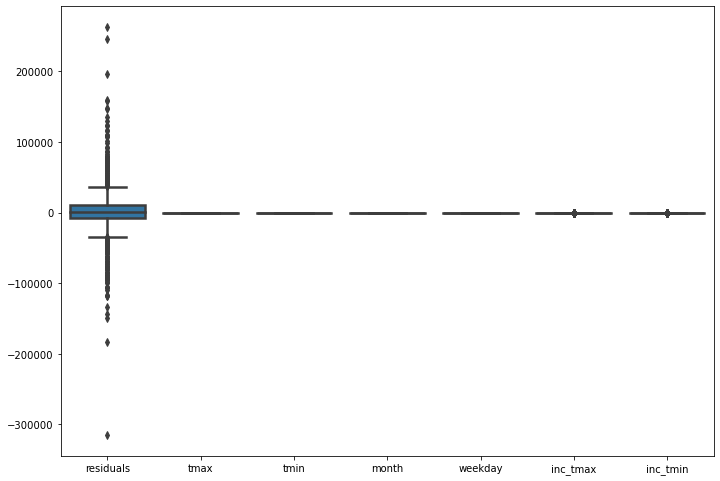

In [259]:
import seaborn as sns
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(data=df_t,linewidth=2.5,ax=ax)

In [260]:
# dividimos entre train y test I should use sklearn function instead of doing it manually
df_t_train = df_t[df_t['fecha'].dt.year < 2021]
df_t_test = df_t[df_t['fecha'].dt.year >= 2021]

In [261]:
X_train = df_t_train.drop(['residuals', 'fecha'], axis = 'columns')
X_test = df_t_test.drop(['residuals', 'fecha'], axis = 'columns')

In [262]:
y_train = df_t_train[['residuals']]
y_test = df_t_test[['residuals']]

In [263]:
from sklearn.tree import DecisionTreeRegressor
regr_1 = DecisionTreeRegressor(max_depth=2, random_state = 7)
regr_2 = DecisionTreeRegressor(max_depth=3, random_state = 7)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=7)

In [264]:
score1 = regr_1.score(X_train, y_train)
print("R-squared:", score1)  
score2 = regr_2.score(X_train, y_train)
print("R-squared:", score2)  

R-squared: 0.08313674026708784
R-squared: 0.1643502449757014


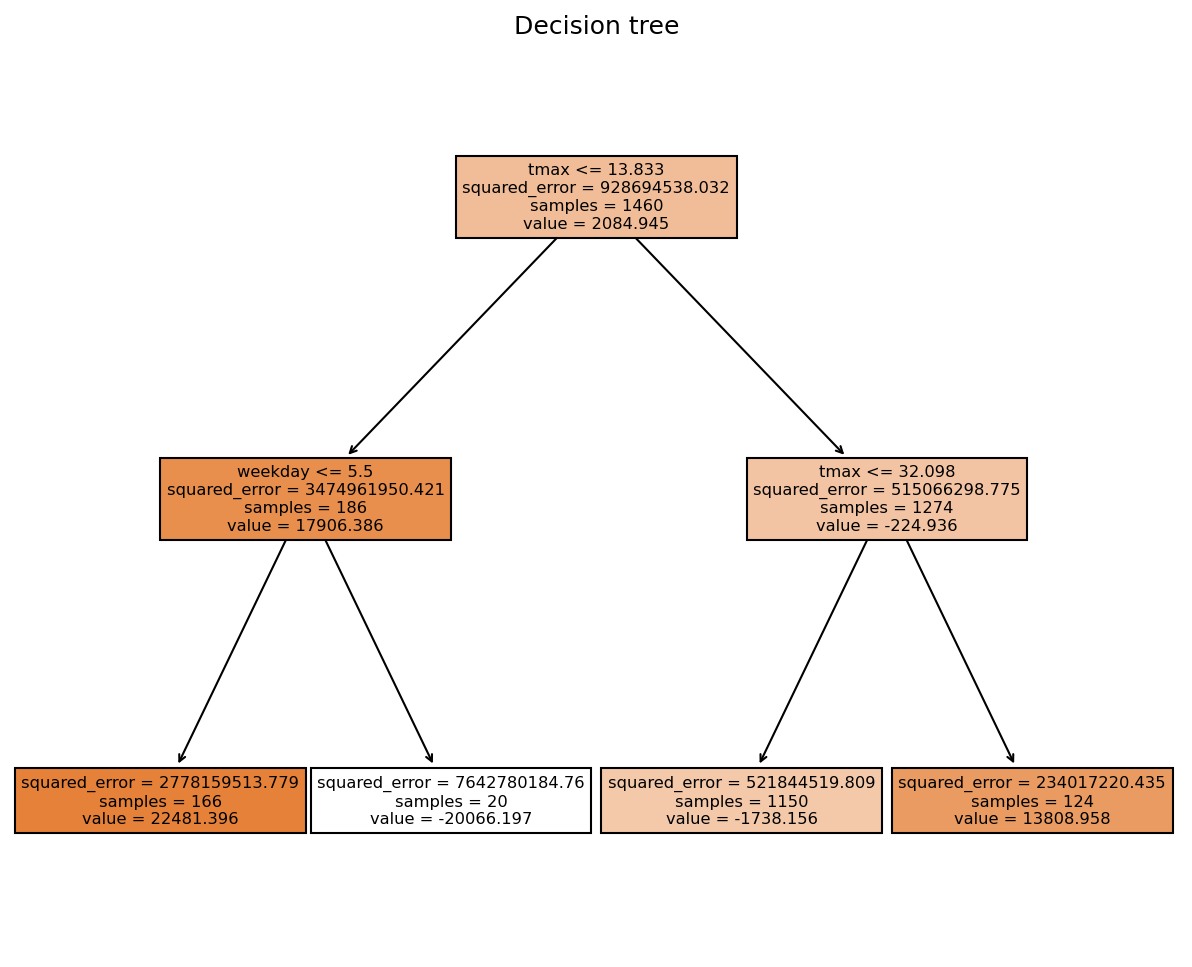

In [265]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,8), dpi=150)
plot_tree(regr_1, filled=True, feature_names=X_train.columns)
plt.title("Decision tree")
plt.show()

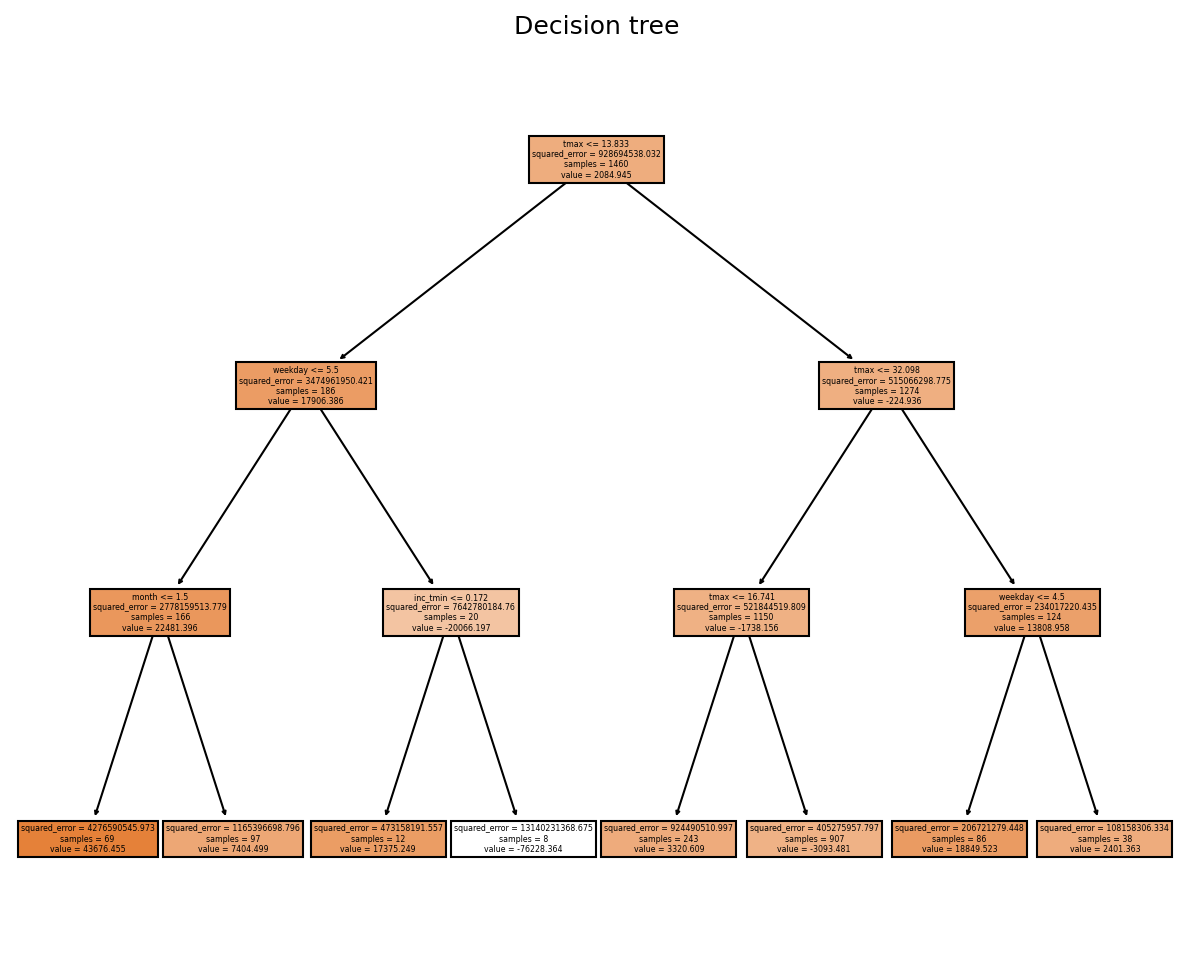

In [266]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,8), dpi=150)
plot_tree(regr_2, filled=True, feature_names=X_train.columns)
plt.title("Decision tree")
plt.show()

In [267]:
y_pred = regr_1.predict(X_test) #Predictions on Test data
y_pred2 = regr_2.predict(X_test)

In [268]:
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score

print('DEPTH 2')
print("MSE : " , np.round(mean_squared_error(y_test, y_pred), 2))
print("MAE : " , np.round(mean_absolute_error(y_test, y_pred), 2))
print("RSquared : " , np.round(r2_score(y_test, y_pred), 2))

print('----------------------------------------')

print('DEPTH 3')
print("MSE : " , np.round(mean_squared_error(y_test, y_pred2), 2))
print("MAE : " , np.round(mean_absolute_error(y_test, y_pred2), 2))
print("RSquared : " , np.round(r2_score(y_test, y_pred2), 2))

DEPTH 2
MSE :  488632593.82
MAE :  12643.86
RSquared :  0.02
----------------------------------------
DEPTH 3
MSE :  517626817.44
MAE :  12756.19
RSquared :  -0.04


El árbol de profundidad dos es el que mejor se adapta a la situación. Los días con una temperatura máxima inferior a 13,8 y que no son fin de semana son los que explican el residual de la serie temporal. Es decir el gas utilizado por los hogares cuando hace frío

He probado escalando los datos ya que el rango de error comparado a la de temperaturas es muy diferente. Sin embargo el árbol pierde interpretabilidad y los errores no son comparables con los anteriores arboles. 

In [269]:
#it's better to scale the variables as they have different range values
from sklearn.preprocessing import StandardScaler

df_t_train_s = df_t.drop('fecha',axis = 'columns')
df_t_test_s = df_t.drop('fecha',axis = 'columns')

scaler = StandardScaler()
s_train= pd.DataFrame(scaler.fit_transform(df_t_train_s), columns=df_t_train_s.columns)
s_test= pd.DataFrame(scaler.fit_transform(df_t_test_s), columns = df_t_test_s.columns)

In [270]:
X_train_s = s_train.drop(['residuals'], axis = 'columns')
X_test_s = s_test.drop(['residuals'], axis = 'columns')
y_train_s = s_train[['residuals']]
y_test_s = s_test[['residuals']]

In [271]:
regr_1s = DecisionTreeRegressor(max_depth=2, random_state = 7, min_samples_leaf = 2)
regr_2s = DecisionTreeRegressor(max_depth=3, random_state = 7)
regr_1s.fit(X_train_s, y_train_s)
regr_2s.fit(X_train_s, y_train_s)

DecisionTreeRegressor(max_depth=3, random_state=7)

In [272]:
score1s = regr_1s.score(X_train_s, y_train_s)
print("R-squared:", score1s)  
score2s = regr_2s.score(X_train_s, y_train_s)
print("R-squared:", score2s)  

R-squared: 0.07923555537065985
R-squared: 0.11813372962658164


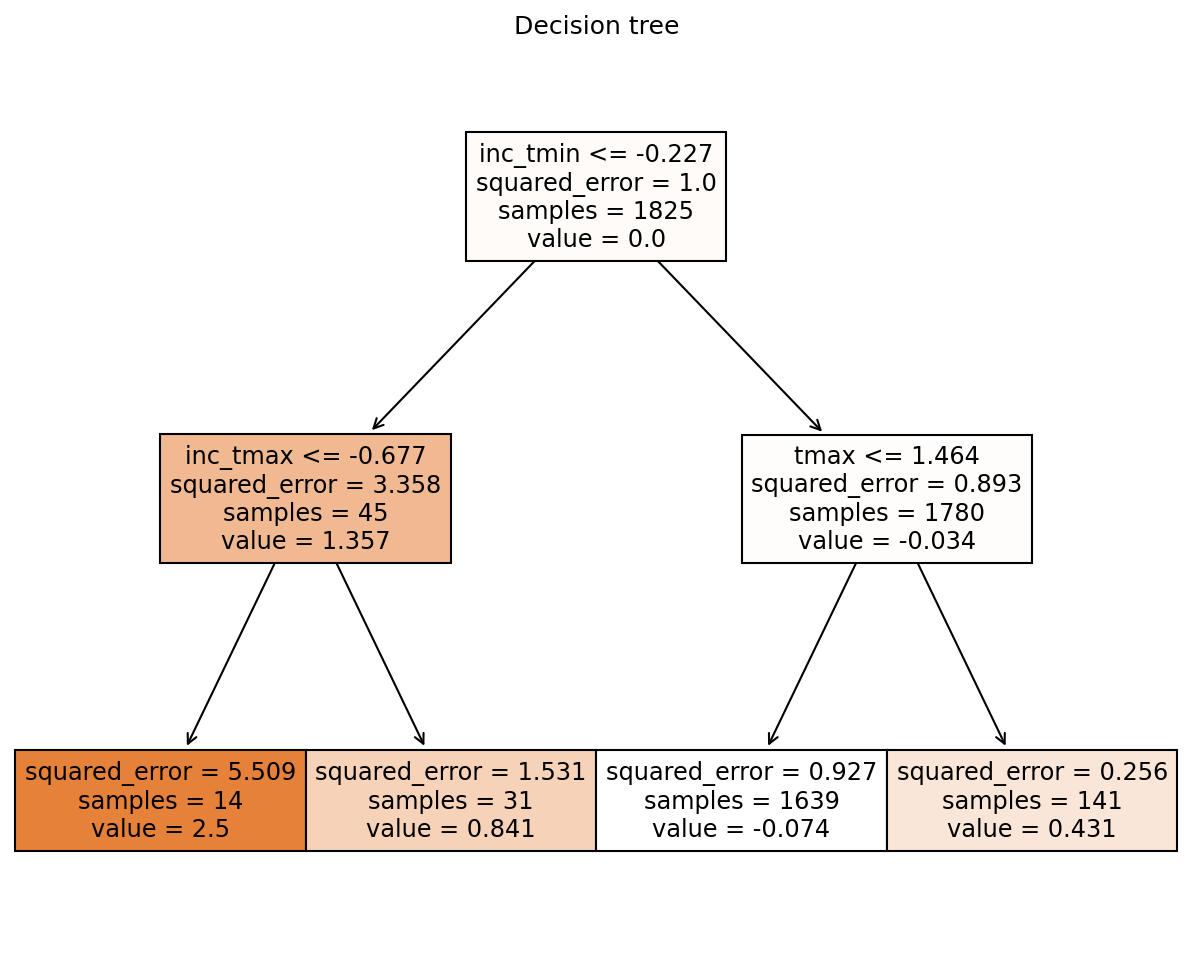

In [273]:
plt.figure(figsize=(10,8), dpi=150)
plot_tree(regr_1s, filled=True, feature_names=X_train_s.columns)
plt.title("Decision tree")
plt.show()

In [274]:
y_pred_s = regr_1s.predict(X_test_s) #Predictions on Test data
y_pred2_s = regr_2s.predict(X_test_s)

In [275]:
print('DEPTH 2')
print("MSE : " , np.round(mean_squared_error(y_test_s, y_pred_s), 2))
print("MAE : " , np.round(mean_absolute_error(y_test_s, y_pred_s), 2))
print("RSquared : " , np.round(r2_score(y_test_s, y_pred_s), 2))

DEPTH 2
MSE :  0.92
MAE :  0.53
RSquared :  0.08
